# <a id='toc1_'></a>[Large Sublimation Event Profiles](#toc0_)
Created October 1, 2024

Author: Daniel Hogan

This notebook will make plots for the different large sublimation events using the SOS dataset. The second portion will use the SAIL TROPOE dataset to make similar plots over a greater vertical distance.

**Table of contents**<a id='toc0_'></a>    
- [Large Sublimation Event Profiles](#toc1_)    
- [Imports and Data](#toc2_)    
    - [Open our SOS data](#toc2_1_1_)    
    - [Open alternative SEB data from SPLASH](#toc2_1_2_)    
    - [Open SAIL TROPOE Data](#toc2_1_3_)    
    - [Open Large Sublimation Events](#toc2_1_4_)    
- [Data Preparation](#toc3_)    
    - [Convert Apogee temperatures](#toc3_1_1_)    
    - [Saturation with respect to ice](#toc3_1_2_)    
    - [Create variables for each desired data product](#toc3_1_3_)    
    - [Mask non-freezing RH wrt ice measurements](#toc3_1_4_)    
- [Select Event](#toc4_)    
    - [Grab value added product from doppler lidar scans](#toc4_1_1_)    
- [ SOS Data Plotting](#toc5_)    
    - [Plotting functions](#toc5_1_1_)    
  - [Vertical Profiles - Relative Humidity wrt Ice + Temperature](#toc5_2_)    
  - [Vertical Profiles - Vapor Pressure Deficit + Potential Temperature](#toc5_3_)    
    - [Vertical Velocity Variance](#toc5_3_1_)    
  - [Time Series - Energy Balance and Turublent Flux Comparisons](#toc5_4_)    
- [Plotting with TROPOE](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports and Data](#toc0_)

In [1]:
import os
os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation')

In [2]:
# general
import datetime as dt
import json
# data 
import xarray as xr 
import numpy as np
import pandas as pd
from scipy import stats as stats 
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
# helper tools
from utils.get_sail_data import get_sail_data
from utils.helper_funcs import create_windrose_df, mean_sounding, simple_sounding, localize_time
import utils.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.4.4


### <a id='toc2_1_1_'></a>[Open our SOS data](#toc0_)

In [3]:
sos_30min = xr.open_dataset('./01_data/processed_data/sos/sos_ds_30M_storage.nc')

# localize time
sos_30min = localize_time(sos_30min)

### <a id='toc2_1_2_'></a>[Open alternative SEB data from SPLASH](#toc0_)

In [4]:
def resample_xarray_dataset(ds, resampling_interval):
    """
    Resamples an xarray Dataset by converting it to a pandas DataFrame,
    flattening the index, performing resampling, and converting back to xarray Dataset.
    
    Parameters:
    - ds (xr.Dataset): Input xarray Dataset to be resampled.
    - resampling_interval (str): Resampling interval string (e.g., '1H', '1D', '1M').
    
    Returns:
    - xr.Dataset: Resampled xarray Dataset.
    """
    attrs_dataset = ds.attrs.copy()
    attrs_vars = {var: ds[var].attrs.copy() for var in ds.variables}

    # Convert dataset to pandas DataFrame and flatten the multi-index
    df = ds.to_dataframe()

    # Perform resampling in pandas using agg, all dimension except size_bins should be averaged, size_bins should be constant
    print("Starting computation...")
    start_time = dt.datetime.now()
    ds_resampled = df.resample(resampling_interval).mean().to_xarray()

    end_time = dt.datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    # Restore attributes to the resampled xarray Dataset
    ds_resampled.attrs.update(attrs_dataset)
    for var in ds_resampled.variables:
        ds_resampled[var].attrs.update(attrs_vars.get(var, {}))

    return ds_resampled


In [5]:
splash_radsys_ds = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/splash_data/radsys_ckp_dataset.nc')
# resample to 30min
splash_radsys_30min_ds = resample_xarray_dataset(splash_radsys_ds, '30min').sel(time=sos_30min.time)

Starting computation...
Duration: 0:00:00.239238


### <a id='toc2_1_3_'></a>[Open SAIL TROPOE Data](#toc0_)

In [6]:
variables = ['pressure','temperature', 'waterVapor', 'lwp','theta','thetae','rh', 'pblh', 'pblh', 'sbih', 'obs_flag', 'cbh', 'cbh_flag']
w23_sail_tropoe = xr.open_dataset('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/tropoe_20221201_20230401.nc')[variables]

# localize time
w23_sail_tropoe = localize_time(w23_sail_tropoe)

### <a id='toc2_1_4_'></a>[Open Large Sublimation Events](#toc0_)

In [8]:
# load in the big events from winter 2023
w23_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_long_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')
w23_spiky_events =pd.read_csv('./01_data/processed_data/sublimation/w23_spiky_evts.csv', index_col=0, date_format='%Y-%m-%d %H:%M:%S')

# get the start and end datetimes of the events
long_events_start = w23_long_events.reset_index().groupby('event_number').first()['time']
long_events_end = w23_long_events.reset_index().groupby('event_number').last()['time']
spiky_events_start = w23_spiky_events.reset_index().groupby('event_number').first()['time']
spiky_events_end = w23_spiky_events.reset_index().groupby('event_number').last()['time']

# convert to UTC time and then to MST and then localize
long_events_start = long_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
long_events_end = long_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
spiky_events_start = spiky_events_start.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)
spiky_events_end = spiky_events_end.dt.tz_localize('UTC').dt.tz_convert('MST').dt.tz_localize(None)

# <a id='toc3_'></a>[Data Preparation](#toc0_)

### <a id='toc3_1_2_'></a>[Saturation with respect to ice](#toc0_)

In [9]:
# correct the RH values to make them with respect to ice
def saturation_vapor_pressure_wrt_ice(T, method='Huang'):
    # from Huang et al. 2018
    if method == 'Huang':
        Ps = np.exp(43.494 - (6545.8 / (T + 278.0)))/((T + 868)**2)
    elif method == 'Magnus':
        # From (Alduchov and Eskridge 1996).
        Ps = 611.21 * np.exp((22.587*T)/(T + 273.86))
    return Ps
def saturation_vapor_pressure_wrt_water(T, method='Huang'):
    if method == 'Huang':
        # from Huang et al. 2018
        Ps = np.exp(34.494 - (4924.99 / (T + 237.1)))/((T+105)**1.57)
    if method == 'Magnus':
    # From (Alduchov and Eskridge 1996).
        Ps = 610.94 * np.exp((17.625*T)/(T + 243.04))
    return Ps

cold_temp_array = np.arange(-20, 0, 1)
warm_temp_array = np.arange(-20, 0, 1)
sat_vap_pres_ice_huang = saturation_vapor_pressure_wrt_ice(cold_temp_array)
sat_vap_pres_ice_magnus= saturation_vapor_pressure_wrt_ice(cold_temp_array, method='Magnus')
sat_vap_pres_water_huang = saturation_vapor_pressure_wrt_water(warm_temp_array)
sat_vap_pres_water_magnus = saturation_vapor_pressure_wrt_water(warm_temp_array, method='Magnus')

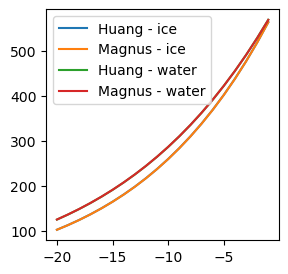

In [10]:
plt.figure(figsize=(3,3))
# Testing to compare
plt.plot(cold_temp_array, sat_vap_pres_ice_huang, label='Huang - ice')
plt.plot(cold_temp_array, sat_vap_pres_ice_magnus, label='Magnus - ice')
plt.plot(warm_temp_array, sat_vap_pres_water_huang, label='Huang - water')
plt.plot(warm_temp_array, sat_vap_pres_water_magnus, label='Magnus - water')
plt.legend()

### Interpolation using diurnal window

In [11]:
def rolling_window_diurnal(df, site, window=dt.timedelta(days=3)):
    """
    This function will take in a dataframe and return a rolling window average for each hour of the day
    """
    # create a new dataframe to hold the results
    subset_df = df[site].copy()
    # print the number of nans
    print(f'Number of NaNs before: {subset_df.isna().sum()}')
    # itierate through the time index
    for i, time in enumerate(subset_df.index):
        # find the missing values
        if np.isnan(subset_df.loc[time]):
            # create a window around the time with missing data
            start_window = time - window
            end_window = time + window
            # get the hourly average for the window
            src = subset_df.loc[start_window:end_window]
            # check if the window has at least 50% measurements data
            if len(src) / 2 >= src.isna().sum():
                interp_val = src.groupby([src.index.hour, src.index.minute]).mean()
                # set a min and max threshold for the interpolation
                interp_val = interp_val.where(interp_val >=0, 0)
                # fill in the missing value
                subset_df.loc[time] = interp_val.loc[time.hour, time.minute]
            else:
                # the value is truly missing
                subset_df.loc[time] = np.nan
    print(f'Number of NaNs after: {subset_df.isna().sum()}')
    return subset_df


### <a id='toc3_1_3_'></a>[Create variables for each desired data product](#toc0_)

Basic Meteorological Variables

In [12]:
sos_30min_RH = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'RH' in var]] 
sos_30min_T = sos_30min[[var for var in hf.TEMPERATURE_VARIABLES if 'T' in var]] * units.units('degC')
sos_30min_winds = sos_30min[[var for var in hf.WIND_VARIABLES if 'spd' in var or 'dir' in var]] 
# surface temperature
sos_30min_Tsurf_d = sos_30min['Tsurfapogee_d'] # can also take spatial mean if I want

In [13]:
# calculate pressure, mixing ratio and air density
heights = np.arange(2,21,1)
pressureprofiles = []
mixingratios = []
airdensities = []
vaporpressures = []
satvaporpressures = []
vpds = []
thetas = []
for h in heights:
    # calculate pressure
    pressure = calc.height_to_pressure_std(
                                calc.pressure_to_height_std(sos_30min['P_10m_c']*units.units('hPa')) - ((10 - h)/1000)*units.units('km'))
    pressure.name = f'P_{h}m_c'
    # calculate mixing ratio
    mixingratio = calc.mixing_ratio_from_relative_humidity(pressure, sos_30min_T[f'T_{h}m_c'], sos_30min_RH[f'RH_{h}m_c'])
    mixingratio.name=f'w_{h}m_c'
    # calculate air density
    airdensity = calc.density(pressure, sos_30min_T[f'T_{h}m_c'], mixingratio)
    airdensity.name = f'rho_{h}m_c'
    # calculate vapor pressure
    vaporpressure = calc.vapor_pressure(pressure, mixingratio)
    vaporpressure.name = f'e_{h}m_c'
    # calculate saturation vapor pressure
    satvaporpressure = saturation_vapor_pressure_wrt_ice(sos_30min_T['T_10m_c'].metpy.dequantify()) * units.units('Pa')
    satvaporpressure.name = f'es_{h}m_c'
    # calculate vapor pressure deficit
    vaporpressuredeficit = satvaporpressure - vaporpressure
    vaporpressuredeficit.name = f'vpd_{h}m_c'
    # calculate potential temperature
    sos_30min_theta = calc.potential_temperature(pressure, sos_30min_T[f'T_{h}m_c'])
    sos_30min_theta.name = f'Theta_{h}m_c'

    # append to lists
    pressureprofiles.append(pressure)
    mixingratios.append(mixingratio)
    airdensities.append(airdensity)
    vaporpressures.append(vaporpressure)
    satvaporpressures.append(satvaporpressure)
    vpds.append(vaporpressuredeficit)
    thetas.append(sos_30min_theta)


# Create xarray datasets
sos_30min_pressure_profiles = xr.merge(pressureprofiles)
sos_30min_mixing_ratio = xr.merge(mixingratios)
sos_30min_airdensity = xr.merge(airdensities) 
sos_30min_vaporpressure = xr.merge(vaporpressures) 
sos_30min_satvaporpressure = xr.merge(satvaporpressures) 
sos_30min_vpd = xr.merge(vpds)
sos_30min_theta = xr.merge(thetas) 

Turbulent Flux Variables

In [14]:
# sublimation rate
sos_30min_Hl_webb_3m = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True).to_xarray()*units.units('J/m^2/s')
# localize the time
sos_30min_Hl_webb_3m['time'] = pd.to_datetime(sos_30min_Hl_webb_3m.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
sos_30min_ec_temp = sos_30min[[var for var in hf.TURBULENCE_VARIABLES if 'w_t_3m' in var]].to_array(dim='3m').mean('3m')

Snow Variables

In [15]:
sos_30min_swe = sos_30min[['SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c']].to_array(dim='snow').mean('snow') # estimate of bulk density
sos_30min_snow_depth_est = (sos_30min_swe)/250 # convert from mm of depth to meters of snow by converting to meters and multiplying by 250 kg/m^3
# blowing snow flux
sos_30min_bsf = sos_30min[[var for var in hf.SNOW_FLUX]].to_array(dim='total').sum('total')

Energy Balance Variables

In [16]:
# SOS radiation
sos_30min_rad = sos_30min[[var for var in hf.RADIAION_VARIABLES if 'R' in var]+['R_lw_up', 'R_lw_down']]
# Fill NA values with np.nan
sos_30min_rad = sos_30min_rad.fillna(np.nan)

# SPLASH radiation
splash_dw_solar = splash_radsys_30min_ds['dw_solar'].where((splash_radsys_30min_ds['dw_solar_qc'] == 0) & (splash_radsys_30min_ds['uw_solar_qc'] == 0), np.nan)
splash_up_solar = splash_radsys_30min_ds['uw_solar'].where((splash_radsys_30min_ds['dw_solar_qc'] == 0) & (splash_radsys_30min_ds['uw_solar_qc'] == 0), np.nan)
splash_dw_ir = splash_radsys_30min_ds['dw_ir'].where((splash_radsys_30min_ds['dw_ir_qc'] == 0)& (splash_radsys_30min_ds['uw_ir_qc'] == 0), np.nan)
splash_up_ir = splash_radsys_30min_ds['uw_ir'].where((splash_radsys_30min_ds['dw_ir_qc'] == 0)& (splash_radsys_30min_ds['uw_ir_qc'] == 0), np.nan)

# remove any times when Rsw_in_9m_d is less than Rsw_out_9m_d
sos_30min_rad = sos_30min_rad.where((sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d'])>-10,np.nan)

# if values are missing, replace with splash values
sos_30min_rad['Rsw_in_9m_d'] = sos_30min_rad['Rsw_in_9m_d'].where(sos_30min_rad['Rsw_in_9m_d'].notnull(), splash_dw_solar)
sos_30min_rad['Rsw_out_9m_d'] = sos_30min_rad['Rsw_out_9m_d'].where(sos_30min_rad['Rsw_out_9m_d'].notnull(), splash_up_solar)
sos_30min_rad['R_lw_down'] = sos_30min_rad['R_lw_down'].where(sos_30min_rad['R_lw_down'].notnull(), splash_dw_ir)
sos_30min_rad['R_lw_up'] = sos_30min_rad['R_lw_up'].where(sos_30min_rad['R_lw_up'].notnull(), splash_up_ir)

# # Interpolate other missing values
for variable in sos_30min_rad.data_vars:
    print(variable)
    sos_30min_rad[variable] = rolling_window_diurnal(sos_30min_rad.to_dataframe(), variable, window=dt.timedelta(days=1, hours=12)).to_xarray()
    print('------------')
# calculate net radiation
sos_30min_rad['rnet'] = (sos_30min_rad['Rsw_in_9m_d'] - sos_30min_rad['Rsw_out_9m_d']) + (sos_30min_rad['R_lw_down'] - sos_30min_rad['R_lw_up'])


# # daytime is anytime when difference between Rsw_in_9m_d is greater than 25 W/m^2
sos_30min_rad['daytime'] = sos_30min_rad['Rsw_in_9m_d']  > 25
sos_30min_rad['nighttime'] = sos_30min_rad['daytime'] == False

Rpile_out_9m_d
Number of NaNs before: 2967
Number of NaNs after: 1341
------------
Rpile_in_9m_d
Number of NaNs before: 2967
Number of NaNs after: 1341
------------
Rsw_in_9m_d
Number of NaNs before: 588
Number of NaNs after: 143
------------
Rsw_out_9m_d
Number of NaNs before: 588
Number of NaNs after: 143
------------
R_lw_up
Number of NaNs before: 727
Number of NaNs after: 225
------------
R_lw_down
Number of NaNs before: 727
Number of NaNs after: 225
------------


### <a id='toc3_1_4_'></a>[Mask non-freezing RH wrt ice measurements](#toc0_)

In [17]:
sos_30min_RH_ice = sos_30min_RH.copy()
# covert to RH with respect to ice by multiplying with the ratio of the saturation vapor pressure of water and ice
for var in sos_30min_RH_ice:
    if 'RH' in var:
        T_var = var.replace('RH', 'T')
        # create a mask where T is below 0
        mask = sos_30min_T[T_var] > 0
        # use the mask to calculate RH with respect to ice
        sos_30min_RH_ice[var] = sos_30min_RH_ice[var].where(mask, sos_30min_RH_ice[var] * saturation_vapor_pressure_wrt_water(sos_30min_T[T_var].values)/saturation_vapor_pressure_wrt_ice(sos_30min_T[T_var].values))

In [18]:
# Constant values
rho_w = 1000 * units.units('kg/m^3') # density of water kg/m^3
g2kg = (1/1000 * units.units('kg/g')) # convert from g to kg
mm_per_meter = 1000 * units.units('mm/m') # convert from m to mm
s_in_hour = 3600 * units.units('seconds/hour') # seconds in an hour
latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
heat_capacity_air = (1005)*units.units('J/kg/C') # J/kg/C

<Axes: xlabel='spd_10m_c', ylabel='tke_10m_c'>

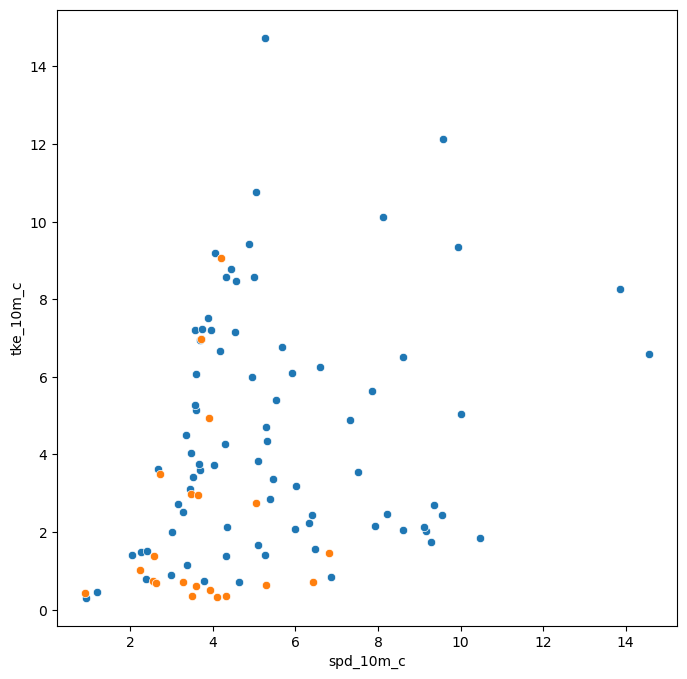

In [19]:
sos_30min_tke_10m = np.sqrt(0.5*(sos_30min['u_u__10m_c']**2 + sos_30min['v_v__10m_c']**2 + sos_30min['w_w__10m_c']**2))
sos_30min_tke_10m.name = 'tke_10m_c'
sos_30min_winds_10m = sos_30min['spd_10m_c']

# merge the datasets and convert to a dataframe
sos_tke_wind_df = xr.merge([sos_30min_tke_10m, sos_30min_winds_10m]).to_dataframe().resample('3H').mean()

fig, ax = plt.subplots(figsize=(8,8))
# sns.scatterplot(data=sos_tke_wind_df, x='spd_10m_c', y='tke_10m_c', ax=ax)
sns.scatterplot(data=sos_tke_wind_df.loc[w23_long_events.index], x='spd_10m_c', y='tke_10m_c', ax=ax)
sns.scatterplot(data=sos_tke_wind_df.loc[w23_spiky_events.index], x='spd_10m_c', y='tke_10m_c', ax=ax)



### Get all average conditions over winter to compare

In [20]:
sos_30min_RH_ice_all = sos_30min_RH_ice.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_T_all = sos_30min_T.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_winds_all = sos_30min_winds.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_snow_depth_all = sos_30min_snow_depth_est.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_bsf_all = sos_30min_bsf.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_Tsurf_d_all = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_mixing_ratio_all = sos_30min_mixing_ratio.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median() * 1000*units.units('g/kg')
sos_30min_vaporpressure_all = sos_30min_vaporpressure.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_satvaporpressure_all = sos_30min_satvaporpressure.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_vpd_all = sos_30min_vpd.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_theta_all = sos_30min_theta.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()
sos_30min_Tsnow_d_all = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].groupby('time.hour').median() * units.units('degC')
sos_30min_Tsnow_uw_all = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].groupby('time.hour').median() * units.units('degC')

# daytime and nighttime
sos_30min_daynight_all = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))[['daytime', 'nighttime']].groupby('time.hour').median()

# radiation
sos_30min_rnet_all = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').median()

### Calculate turbulent heat fluxes for sublimation
sos_30min_latent_heat_all = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').median()
sos_30min_sublimation_all = (sos_30min_latent_heat_all) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr

# using the 3 meter data
sos_30min_sensible_heat_all = heat_capacity_air*(sos_30min_ec_temp.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()*units.units('deg * m/s')*sos_30min_airdensity.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').median()['rho_3m_c']) # convert to W/m^2 from degC * m/s

# name all the variables
sos_30min_bsf_all.name = 'bsf'
sos_30min_sublimation_all.name = 'sublimation'
sos_30min_latent_heat_all.name = 'latent_heat'
sos_30min_sensible_heat_all.name = 'sensible_heat'

In [21]:
# get top quartile of daily sublimation
sos_30min_RH_ice_top_quartile = sos_30min_RH_ice.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_T_top_quartile = sos_30min_T.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_winds_top_quartile = sos_30min_winds.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_vaporpressure_top_quartile = sos_30min_vaporpressure.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_vpd_top_quartile = sos_30min_vpd.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_Tsurf_d_top_quartile = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)
sos_30min_Tsnow_d_top_quartile = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].groupby('time.hour').quantile(0.75) * units.units('degC')
sos_30min_Tsnow_uw_top_quartile = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].groupby('time.hour').quantile(0.75) * units.units('degC')

# radiation
sos_30min_rnet_top_quartile = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').quantile(0.75)

### Calculate turbulent heat fluxes for sublimation
# Latent heat flux
sos_30min_latent_heat_top_quartile = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').quantile(0.75)
sos_30min_sublimation_top_quartile = (sos_30min_latent_heat_top_quartile) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr

# Sensible heat flux
sos_30min_sensible_heat_top_quartile = heat_capacity_air*(sos_30min_ec_temp.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)*units.units('deg * m/s')*sos_30min_airdensity.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.75)['rho_3m_c']) # convert to W/m^2 from degC * m

# name all the variables
sos_30min_sublimation_top_quartile.name = 'sublimation'
sos_30min_latent_heat_top_quartile.name = 'latent_heat'
sos_30min_sensible_heat_top_quartile.name = 'sensible_heat'

In [22]:
# get bottom quartile of daily sublimation
sos_30min_RH_ice_bottom_quartile = sos_30min_RH_ice.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_T_bottom_quartile = sos_30min_T.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_winds_bottom_quartile = sos_30min_winds.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_vaporpressure_bottom_quartile = sos_30min_vaporpressure.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_vpd_bottom_quartile = sos_30min_vpd.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_Tsurf_d_bottom_quartile = sos_30min_Tsurf_d.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)
sos_30min_Tsnow_d_bottom_quartile = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].groupby('time.hour').quantile(0.25) * units.units('degC')
sos_30min_Tsnow_uw_bottom_quartile = sos_30min.sel(time=slice('2022-12-01','2023-03-31'))[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].groupby('time.hour').quantile(0.25) * units.units('degC')

# radiation
sos_30min_rnet_bottom_quartile = sos_30min_rad.sel(time=slice('2022-12-01','2023-03-31'))['rnet'].groupby('time.hour').quantile(0.25)

### Calculate turbulent heat fluxes for sublimation
sos_30min_latent_heat_bottom_quartile = sos_30min_Hl_webb_3m.sel(time=slice('2022-12-01','2023-03-31'))['sos_3m'].groupby('time.hour').quantile(0.25)
sos_30min_sublimation_bottom_quartile = (sos_30min_latent_heat_bottom_quartile) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr

# using the 3 meter data
sos_30min_sensible_heat_bottom_quartile = heat_capacity_air*(sos_30min_ec_temp.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)*units.units('deg * m/s')*sos_30min_airdensity.sel(time=slice('2022-12-01','2023-03-31')).groupby('time.hour').quantile(0.25)['rho_3m_c']) # convert to W/m^2 from degC * m

# name all the variables
sos_30min_sublimation_bottom_quartile.name = 'sublimation'
sos_30min_latent_heat_bottom_quartile.name = 'latent_heat'
sos_30min_sensible_heat_bottom_quartile.name = 'sensible_heat'

### Get Average Conditions During All Events

In [23]:
all_events_RH_ice = []
all_events_T = []
all_events_winds = []
all_events_snow_depth = []
all_events_Tsurf_d = []
all_events_mixing_ratio = []
all_events_vaporpressure = []
all_events_satvaporpressure = []
all_events_vpd = []
all_events_theta = []
all_events_Tsnow_d = []
all_events_Tsnow_uw = []
all_events_daynight = []
all_events_rnet = []
all_events_sensible_heat = []
all_events_latent_heat = []
all_events_sublimation = []

for i in range(len(long_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = long_events_start.iloc[i], long_events_end.iloc[i]
    
    # get data for plots
    sos_30min_RH_ice_sel = sos_30min_RH_ice.sel(time=slice(start, end))
    sos_30min_T_sel = sos_30min_T.sel(time=slice(start, end))
    sos_30min_winds_sel = sos_30min_winds.sel(time=slice(start, end))
    sos_30min_Tsurf_d_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
    sos_30min_mixing_ratio_sel = sos_30min_mixing_ratio.sel(time=slice(start, end)) * 1000*units.units('g/kg')
    sos_30min_vaporpressure_sel = sos_30min_vaporpressure.sel(time=slice(start, end))
    sos_30min_satvaporpressure_sel = sos_30min_satvaporpressure.sel(time=slice(start, end))
    sos_30min_vpd_sel = sos_30min_vpd.sel(time=slice(start, end))
    sos_30min_theta_sel = sos_30min_theta.sel(time=slice(start, end))
    sos_30min_Tsnow_d_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].sel(time=slice(start, end))*units.units('degC')
    sos_30min_Tsnow_uw_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].sel(time=slice(start, end))*units.units('degC')

    # daytime and nighttime
    sos_30min_daynight_sel = sos_30min_rad.sel(time=slice(start, end))[['daytime', 'nighttime']]

    # radiation
    sos_30min_rnet_sel = sos_30min_rad['rnet'].sel(time=slice(start, end))

    # Latent heat flux and sublimation
    sos_30min_latent_heat_sel = sos_30min_Hl_webb_3m.sel(time=slice(start, end))['sos_3m']
    sos_30min_sublimation_sel = (sos_30min_latent_heat_sel) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr
    
    # Sensible heat flux 
    sos_30min_sensible_heat_sel = heat_capacity_air*(sos_30min_ec_temp*units.units('deg * m/s')*sos_30min_airdensity['rho_3m_c']).sel(time=slice(start, end)) # convert to W/m^2 from degC * m/s
    
    # name all the variables
    sos_30min_sublimation_sel.name = 'sublimation'
    sos_30min_latent_heat_sel.name = 'latent_heat'
    sos_30min_sensible_heat_sel.name = 'sensible_heat'

    # append all events to their respective lists
    all_events_RH_ice.append(sos_30min_RH_ice_sel)
    all_events_T.append(sos_30min_T_sel)
    all_events_winds.append(sos_30min_winds_sel)
    all_events_Tsurf_d.append(sos_30min_Tsurf_d_sel)
    all_events_mixing_ratio.append(sos_30min_mixing_ratio_sel)
    all_events_vaporpressure.append(sos_30min_vaporpressure_sel)
    all_events_satvaporpressure.append(sos_30min_satvaporpressure_sel)
    all_events_vpd.append(sos_30min_vpd_sel)
    all_events_theta.append(sos_30min_theta_sel)
    all_events_Tsnow_d.append(sos_30min_Tsnow_d_sel)
    all_events_Tsnow_uw.append(sos_30min_Tsnow_uw_sel)
    all_events_daynight.append(sos_30min_daynight_sel)
    all_events_rnet.append(sos_30min_rnet_sel)
    all_events_sensible_heat.append(sos_30min_sensible_heat_sel)
    all_events_latent_heat.append(sos_30min_latent_heat_sel)
    all_events_sublimation.append(sos_30min_sublimation_sel)

# concatenate all the events
all_events_RH_ice_ds = xr.concat(all_events_RH_ice, dim='time').groupby('time.hour').mean()
all_events_T_ds = xr.concat(all_events_T, dim='time').groupby('time.hour').mean()
all_events_winds_ds = xr.concat(all_events_winds, dim='time').groupby('time.hour').mean()
all_events_Tsurf_d_ds = xr.concat(all_events_Tsurf_d, dim='time').groupby('time.hour').mean()
all_events_mixing_ratio_ds = xr.concat(all_events_mixing_ratio, dim='time').groupby('time.hour').mean()
all_events_vaporpressure_ds = xr.concat(all_events_vaporpressure, dim='time').groupby('time.hour').mean()
all_events_satvaporpressure_ds = xr.concat(all_events_satvaporpressure, dim='time').groupby('time.hour').mean()
all_events_vpd_ds = xr.concat(all_events_vpd, dim='time').groupby('time.hour').mean()
all_events_theta_ds = xr.concat(all_events_theta, dim='time').groupby('time.hour').mean()
all_events_Tsnow_d_ds = xr.concat(all_events_Tsnow_d, dim='time').groupby('time.hour').mean()
all_events_Tsnow_uw_ds = xr.concat(all_events_Tsnow_uw, dim='time').groupby('time.hour').mean()
all_events_daynight_ds = xr.concat(all_events_daynight, dim='time').groupby('time.hour').mean()
all_events_rnet_ds = xr.concat(all_events_rnet, dim='time').groupby('time.hour').mean()
all_events_sensible_heat_ds = xr.concat(all_events_sensible_heat, dim='time').groupby('time.hour').mean()
all_events_latent_heat_ds = xr.concat(all_events_latent_heat, dim='time').groupby('time.hour').mean()
all_events_sublimation_ds = xr.concat(all_events_sublimation, dim='time').groupby('time.hour').mean()


In [24]:
all_short_events_RH_ice = []
all_short_events_T = []
all_short_events_winds = []
all_short_events_snow_depth = []
all_short_events_Tsurf_d = []
all_short_events_mixing_ratio = []
all_short_events_vaporpressure = []
all_short_events_satvaporpressure = []
all_short_events_vpd = []
all_short_events_theta = []
all_short_events_Tsnow_d = []
all_short_events_Tsnow_uw = []
all_short_events_daynight = []
all_short_events_rnet = []
all_short_events_sensible_heat = []
all_short_events_latent_heat = []
all_short_events_sublimation = []

for i in range(len(spiky_events_start)):
    # now lets select a large sublimation event to visualize
    start, end = spiky_events_start.iloc[i].date(), spiky_events_end.iloc[i].date() + dt.timedelta(days=1)
    
    # get data for plots
    sos_30min_RH_ice_sel = sos_30min_RH_ice.sel(time=slice(start, end))
    sos_30min_T_sel = sos_30min_T.sel(time=slice(start, end))
    sos_30min_winds_sel = sos_30min_winds.sel(time=slice(start, end))
    sos_30min_Tsurf_d_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
    sos_30min_mixing_ratio_sel = sos_30min_mixing_ratio.sel(time=slice(start, end)) * 1000*units.units('g/kg')
    sos_30min_vaporpressure_sel = sos_30min_vaporpressure.sel(time=slice(start, end))
    sos_30min_satvaporpressure_sel = sos_30min_satvaporpressure.sel(time=slice(start, end))
    sos_30min_vpd_sel = sos_30min_vpd.sel(time=slice(start, end))
    sos_30min_theta_sel = sos_30min_theta.sel(time=slice(start, end))
    sos_30min_Tsnow_d_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].sel(time=slice(start, end))*units.units('degC')
    sos_30min_Tsnow_uw_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].sel(time=slice(start, end))*units.units('degC')

    # daytime and nighttime
    sos_30min_daynight_sel = sos_30min_rad.sel(time=slice(start, end))[['daytime', 'nighttime']]

    # radiation
    sos_30min_rnet_sel = sos_30min_rad['rnet'].sel(time=slice(start, end))

    # Latent heat flux and sublimation
    sos_30min_latent_heat_sel = sos_30min_Hl_webb_3m.sel(time=slice(start, end))['sos_3m']
    sos_30min_sublimation_sel = (sos_30min_latent_heat_sel) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr
    
    # Sensible heat flux 
    sos_30min_sensible_heat_sel = heat_capacity_air*(sos_30min_ec_temp*units.units('deg * m/s')*sos_30min_airdensity['rho_3m_c']).sel(time=slice(start, end)) # convert to W/m^2 from degC * m/s
    
    # name all_short the variables
    sos_30min_sublimation_sel.name = 'sublimation'
    sos_30min_latent_heat_sel.name = 'latent_heat'
    sos_30min_sensible_heat_sel.name = 'sensible_heat'

    # append all_short events to their respective lists
    all_short_events_RH_ice.append(sos_30min_RH_ice_sel)
    all_short_events_T.append(sos_30min_T_sel)
    all_short_events_winds.append(sos_30min_winds_sel)
    all_short_events_Tsurf_d.append(sos_30min_Tsurf_d_sel)
    all_short_events_mixing_ratio.append(sos_30min_mixing_ratio_sel)
    all_short_events_vaporpressure.append(sos_30min_vaporpressure_sel)
    all_short_events_satvaporpressure.append(sos_30min_satvaporpressure_sel)
    all_short_events_vpd.append(sos_30min_vpd_sel)
    all_short_events_theta.append(sos_30min_theta_sel)
    all_short_events_Tsnow_d.append(sos_30min_Tsnow_d_sel)
    all_short_events_Tsnow_uw.append(sos_30min_Tsnow_uw_sel)
    all_short_events_daynight.append(sos_30min_daynight_sel)
    all_short_events_rnet.append(sos_30min_rnet_sel)
    all_short_events_sensible_heat.append(sos_30min_sensible_heat_sel)
    all_short_events_latent_heat.append(sos_30min_latent_heat_sel)
    all_short_events_sublimation.append(sos_30min_sublimation_sel)

# concatenate all_short the events
all_short_events_RH_ice_ds = xr.concat(all_short_events_RH_ice, dim='time').groupby('time.hour').mean()
all_short_events_T_ds = xr.concat(all_short_events_T, dim='time').groupby('time.hour').mean()
all_short_events_winds_ds = xr.concat(all_short_events_winds, dim='time').groupby('time.hour').mean()
all_short_events_Tsurf_d_ds = xr.concat(all_short_events_Tsurf_d, dim='time').groupby('time.hour').mean()
all_short_events_mixing_ratio_ds = xr.concat(all_short_events_mixing_ratio, dim='time').groupby('time.hour').mean()
all_short_events_vaporpressure_ds = xr.concat(all_short_events_vaporpressure, dim='time').groupby('time.hour').mean()
all_short_events_satvaporpressure_ds = xr.concat(all_short_events_satvaporpressure, dim='time').groupby('time.hour').mean()
all_short_events_vpd_ds = xr.concat(all_short_events_vpd, dim='time').groupby('time.hour').mean()
all_short_events_theta_ds = xr.concat(all_short_events_theta, dim='time').groupby('time.hour').mean()
all_short_events_Tsnow_d_ds = xr.concat(all_short_events_Tsnow_d, dim='time').groupby('time.hour').mean()
all_short_events_Tsnow_uw_ds = xr.concat(all_short_events_Tsnow_uw, dim='time').groupby('time.hour').mean()
all_short_events_daynight_ds = xr.concat(all_short_events_daynight, dim='time').groupby('time.hour').mean()
all_short_events_rnet_ds = xr.concat(all_short_events_rnet, dim='time').groupby('time.hour').mean()
all_short_events_sensible_heat_ds = xr.concat(all_short_events_sensible_heat, dim='time').groupby('time.hour').mean()
all_short_events_latent_heat_ds = xr.concat(all_short_events_latent_heat, dim='time').groupby('time.hour').mean()
all_short_events_sublimation_ds = xr.concat(all_short_events_sublimation, dim='time').groupby('time.hour').mean()


In [25]:
long_events_start

event_number
1    2022-12-12 05:00:00
2    2022-12-13 08:00:00
3    2022-12-21 08:00:00
4    2023-02-08 08:00:00
5    2023-02-18 23:00:00
6    2023-02-26 08:00:00
7    2023-03-04 17:00:00
8    2023-03-06 05:00:00
9    2023-03-08 11:00:00
10   2023-03-31 02:00:00
Name: time, dtype: datetime64[ns]

# <a id='toc4_'></a>[Select Event](#toc0_)

In [26]:
# now lets select a large sublimation event to visualize
start, end = long_events_start.iloc[3], long_events_end.iloc[3]
# start, end = spiky_events_start.iloc[0] - dt.timedelta(hours=6), spiky_events_end.iloc[0] + dt.timedelta(hours=6)
print(start, end)
# get data for plots
sos_30min_RH_ice_sel = sos_30min_RH_ice.sel(time=slice(start, end))
sos_30min_T_sel = sos_30min_T.sel(time=slice(start, end))
sos_30min_winds_sel = sos_30min_winds.sel(time=slice(start, end))
sos_30min_snow_depth_sel = sos_30min_snow_depth_est.sel(time=slice(start, end))
sos_30min_bsf_sel = sos_30min_bsf.sel(time=slice(start, end))
sos_30min_Tsurf_d_sel = sos_30min_Tsurf_d.sel(time=slice(start, end))
sos_30min_mixing_ratio_sel = sos_30min_mixing_ratio.sel(time=slice(start, end)) * 1000*units.units('g/kg')
sos_30min_vaporpressure_sel = sos_30min_vaporpressure.sel(time=slice(start, end))
sos_30min_satvaporpressure_sel = sos_30min_satvaporpressure.sel(time=slice(start, end))
sos_30min_vpd_sel = sos_30min_vpd.sel(time=slice(start, end))
sos_30min_theta_sel = sos_30min_theta.sel(time=slice(start, end))
sos_30min_Tsnow_d_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_d' in val]].sel(time=slice(start, end))*units.units('degC')
sos_30min_Tsnow_uw_sel = sos_30min[[val for val in sos_30min.data_vars if 'Tsnow' in val if '_uw' in val]].sel(time=slice(start, end))*units.units('degC')

# daytime and nighttime
sos_30min_daynight_sel = sos_30min_rad.sel(time=slice(start, end))[['daytime', 'nighttime']]

# radiation
sos_30min_rnet_sel = sos_30min_rad['rnet'].sel(time=slice(start, end))

# TROPOE data
try:
    w23_sail_tropoe_sel = w23_sail_tropoe.sel(time=slice(start, end), height=slice(0,3)).resample(time='30min').mean()
except:
    print('no tropoe data')

### Calculate turbulent heat fluxes for sublimation
# Constant values
rho_w = 1000 * units.units('kg/m^3') # density of water kg/m^3
g2kg = (1/1000 * units.units('kg/g')) # convert from g to kg
mm_per_meter = 1000 * units.units('mm/m') # convert from m to mm
s_in_hour = 3600 * units.units('seconds/hour') # seconds in an hour
latent_heat_sublimation = 2.835e6 * units.units('J/kg') # latent heat of sublimation J/kg
# heat_capacity_air units J/kg/C
heat_capacity_air = (1005)*units.units('J/kg/C') # J/kg/C
sos_30min_latent_heat_sel = sos_30min_Hl_webb_3m.sel(time=slice(start, end))['sos_3m']
sos_30min_sublimation_sel = (sos_30min_latent_heat_sel) *s_in_hour * mm_per_meter / latent_heat_sublimation / rho_w # convert from g/m^2/s to mm/hr
# using the 3 meter data
sos_30min_sensible_heat_sel = heat_capacity_air*(sos_30min_ec_temp*units.units('deg * m/s')*sos_30min_airdensity['rho_3m_c']).sel(time=slice(start, end)) # convert to W/m^2 from degC * m/s

2023-02-08 08:00:00 2023-02-08 20:00:00


In [27]:
def get_near_surface_snow_temp(tsnow):
    return (tsnow.to_dataframe().max(axis=0) - tsnow.to_dataframe().min(axis=0)).diff().idxmax()

In [28]:
# name all the variables
sos_30min_bsf_sel.name = 'bsf'
sos_30min_sublimation_sel.name = 'sublimation'
sos_30min_latent_heat_sel.name = 'latent_heat'
sos_30min_sensible_heat_sel.name = 'sensible_heat'

### <a id='toc4_1_1_'></a>[Grab value added product from doppler lidar scans](#toc0_)
This is to visualize the vertical velocity variance (w'w') -- an alogory for turbulence

In [29]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

In [30]:
sail_datastream= "gucdlprofwstats4newsM1.c1"
storage_directory = '/home/dlhogan/GitHub/Synoptic-Sublimation/01_data/processed_data/sail/gucdlprofwstats'
# create empty data dictionary
data_loc_dict = {}

if (os.path.exists(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")): 
        print(f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc already exists")
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        wstats_data = xr.open_dataset(os.path.join(storage_directory,f"{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc"))
else:
        wstats_data = get_sail_data(api_username,
                                        api_token,
                                        sail_datastream,
                                        startdate=start.strftime('%Y%m%d'),
                                        enddate=end.strftime('%Y%m%d'))
        wstats_data.to_netcdf(f"{storage_directory}/{sail_datastream[:-3]}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.nc")

[DOWNLOADING] gucdlprofwstats4newsM1.c1.20230208.000000.nc


In [31]:
# convert to dataframe
wstats_df = wstats_data.to_dataframe().reset_index()
# wstats_df = utils.modify_df_timezone(wstats_data.to_dataframe().reset_index(), 'UTC', 'US/Mountain')
wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
wstats_df['height_low'] = wstats_df['height'] - 15
wstats_df['height_high'] = wstats_df['height'] + 15
wstats_df = wstats_df.rename(columns={'w_variance': 'value'})

# <a id='toc5_'></a>[ SOS Data Plotting](#toc0_)

### <a id='toc5_1_1_'></a>[Plotting functions](#toc0_)

In [32]:
# prepare data for wind barbs
def create_wind_barbs(wind_data, level):
    spd = wind_data[[var for var in hf.WIND_VARIABLES if f'spd_{level}m' in var]].to_pandas()
    dir = wind_data[[var for var in hf.WIND_VARIABLES if f'dir_{level}m' in var]].to_pandas()
    md = 270 - dir.values
    md[md < 0] += 360
    u = (spd * np.cos(np.deg2rad(md))).mean(axis=1).values
    v = (spd * np.sin(np.deg2rad(md))).mean(axis=1).values
    time = wind_data.time.values
    level = np.ones_like(u) * level
    return u,v,time,level

In [33]:
def variable_linear_regression(ds1, ds2, daynight=None):
    ds = xr.merge([ds1, ds2])
    if daynight:
        # chek if time is a dimension
        if 'time' not in ds.dims:
            # get values during daytime
            ds_day = ds.where(ds.sel(hour=daynight['daytime']>0.6), drop=True).dropna(dim='hour')
            # get values during nighttime
            ds_night = ds.where(ds.sel(hour=daynight['nighttime']>0.6), drop=True).dropna(dim='hour')
            # convert to bool if greater than 0
            daynight['daytime'] = daynight['daytime'] > 0.6
            daynight['nighttime'] = daynight['nighttime'] > 0.6
        elif len(daynight['daytime'].time) < len(ds.time):
            # daytime are hours between 14 and 00
            day_hours = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]
            ds_day = ds.where(ds.time.dt.hour.isin(day_hours), drop=True).dropna(dim='time')
            # nighttime are hours between 1 and 13
            night_hours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
            ds_night = ds.where(ds.time.dt.hour.isin(night_hours), drop=True).dropna(dim='time')
        else:
            # get values during daytime
            ds_day = ds.where(ds.sel(time=daynight['daytime']), drop=True).dropna(dim='time')
            # get values during nighttime
            ds_night = ds.where(ds.sel(time=daynight['nighttime']), drop=True).dropna(dim='time')
        # calculate linear regression for daytime
        slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(ds_day[ds1.name].values, ds_day[ds2.name].values)
        X_day = ds_day[ds1.name].values
        Y_day = slope_day * X_day + intercept_day
        # calculate linear regression for nighttime
        slope_night, intercept_night, r_value_night, p_value_night, std_err_night = stats.linregress(ds_night[ds1.name].values, ds_night[ds2.name].values)
        X_night = ds_night[ds1.name].values
        Y_night = slope_night * X_night + intercept_night
        results_dict = dict(
            X_day=X_day,
            Y_day=Y_day,
            r_value_day=r_value_day,
            X_night=X_night,
            Y_night=Y_night,
            r_value_night=r_value_night,
            combined_ds=ds
        )
        return results_dict
        
    else:
        ds = ds.dropna(dim='time')
        slope, intercept, r_value, p_value, std_err = stats.linregress(ds[ds1.name].values, ds[ds2.name].values)
        X = ds[ds1.name].values
        Y = slope * X + intercept
    return dict(X=X, Y=Y, slope=slope, r_value=r_value, combined_ds=ds)

In [34]:
# Define the colors: brown, white, and pink
colors = ['goldenrod', 'white', 'magenta']

# Create the colormap
cmap = LinearSegmentedColormap.from_list('brown_white_pink', colors)
cmap_r = LinearSegmentedColormap.from_list('brown_white_pink_r', colors[::-1])

## <a id='toc5_2_'></a>[Vertical Profiles - Relative Humidity wrt Ice + Temperature](#toc0_)

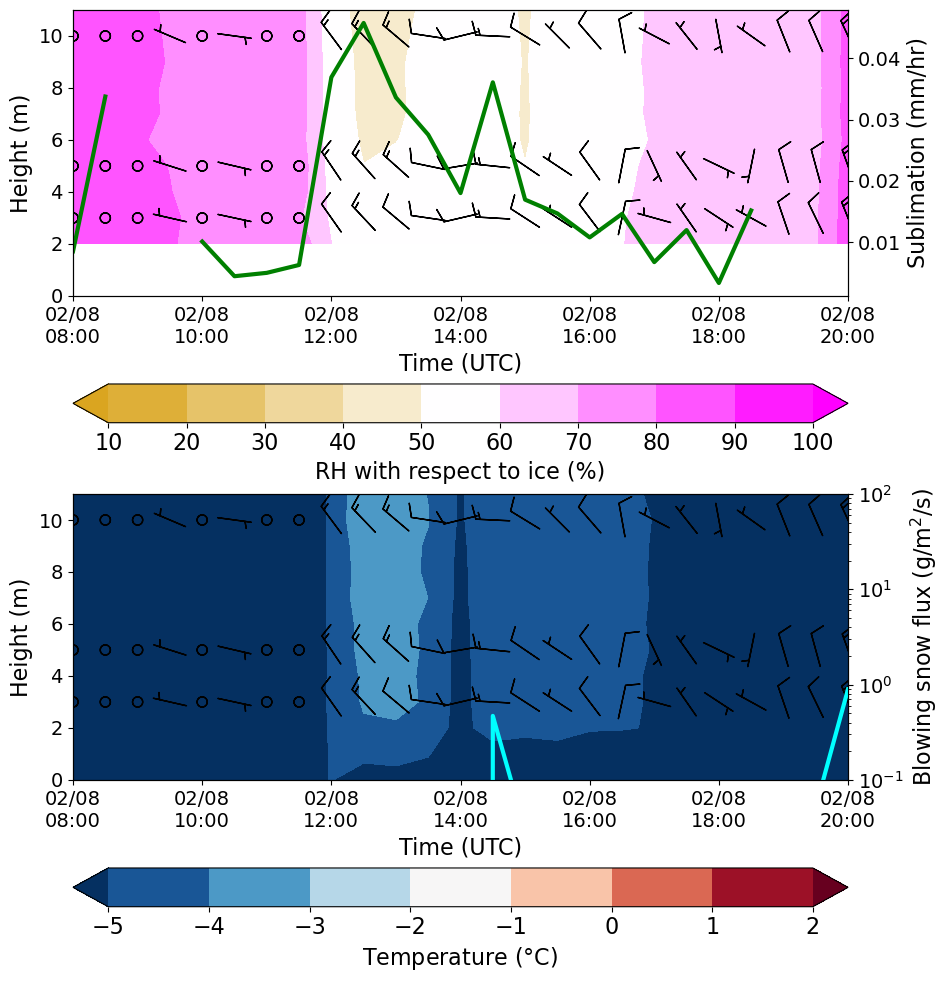

In [35]:
plt.style.use('default')
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,12))
fig.subplots_adjust(hspace=0.1)
x = sos_30min_RH_ice_sel.time.values
y_rh = np.arange(2,12,1)
z_rh = sos_30min_RH_ice_sel.to_pandas().T.iloc[0:10]
z_t = sos_30min_T_sel.to_pandas().T.iloc[0:10]
# linear interpolate missing values
z_rh = z_rh.interpolate(method='linear', limit=2)

y_t = np.arange(0,12,1)
z_t.loc['T_0m_c',:] = sos_30min_Tsurf_d_sel.to_pandas().values
z_t.loc['T_1m_c',:] = np.nan
z_t = z_t.loc[['T_0m_c', 'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 'T_11m_c',]]
z_t = z_t.interpolate(method='linear')

# Plot the contours of RH
ax = axs[0]
# ax.contour(x, y, z_rh, colors='k', levels=np.arange(40,101,10))
c_rh = ax.contourf(x, y_rh, z_rh, cmap=cmap, levels=np.arange(10,101,10), extend='both')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation (mm/hr)')
ax2.set_ylabel('Sublimation (mm/hr)', fontsize=16)
# add wind barbs at 10m every 9 measurements
barb_increments = dict(half=2.5, full=5, flag=26)
if len(sos_30min_winds_sel.time) > 36:
    interval = 6
else:
    interval = 1
barb_data = [[create_wind_barbs(sos_30min_winds_sel, 3)],
             [create_wind_barbs(sos_30min_winds_sel, 5)],
             [create_wind_barbs(sos_30min_winds_sel, 10)]]
            #  [create_wind_barbs(sos_30min_winds_sel, 15)],
            #  [create_wind_barbs(sos_30min_winds_sel, 20)]]
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')

cbar1 = fig.colorbar(c_rh, ax=ax, orientation='horizontal', pad=0.2)
ax.set_xlabel('Time (UTC)', fontsize=16)
ax.set_ylabel('Height (m)', fontsize=16)
ax.set_ylim(0,11)

# increase the tick size
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
cbar1.ax.tick_params(labelsize=16)
cbar1.set_label(label='RH with respect to ice (%)',size=16)

# Format the x-axis ticks to rotate 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency


# Second plot contours of temperature
ax= axs[1]

c_t = ax.contourf(x, y_t, z_t, cmap='RdBu_r', levels=np.arange(-5,3,1), extend='both')
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')
ax2 = ax.twinx()
# also think of adding the sublimation rate
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux (g/m$^2$/s)', fontsize=16)
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
cbar2 = fig.colorbar(c_t, ax=ax, orientation='horizontal', pad=0.2)
ax.set_xlabel('Time (UTC)', fontsize=16)
ax.set_ylabel('Height (m)', fontsize=16)
ax.set_ylim(0,11)

# increase the tick size
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label(label='Temperature ($\degree$C)',size=16)

# Format the x-axis ticks to rotate 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency


## <a id='toc5_3_'></a>[Vertical Profiles - Vapor Pressure Deficit + Potential Temperature](#toc0_)

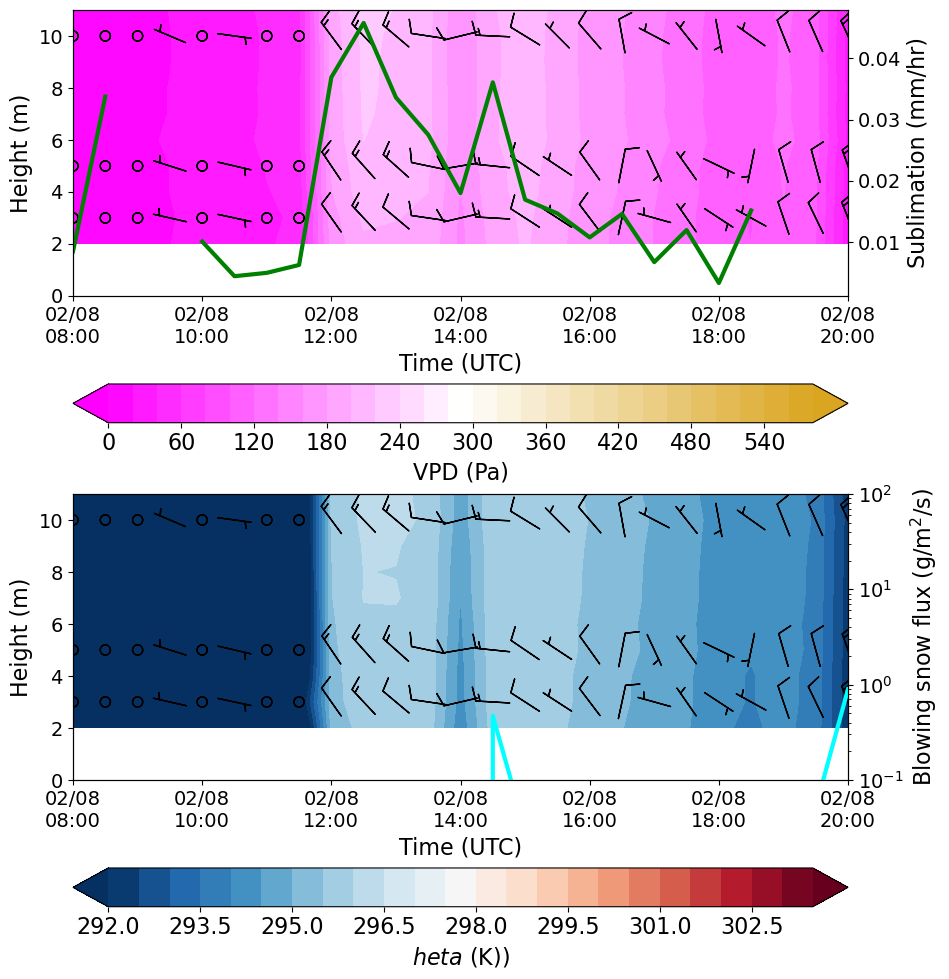

In [36]:
plt.style.use('default')
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,12))
fig.subplots_adjust(hspace=0.1)
x = sos_30min_vpd_sel.time.values
y = np.arange(2,12,1)
z_vpd = sos_30min_vpd_sel.to_pandas().T.iloc[0:10]
z_t = sos_30min_theta_sel.to_pandas().T.iloc[0:10]
# linear interpolate missing values
z_vpd = z_vpd.interpolate(method='linear', limit=2)
# z_t = z_t.interpolate(method='linear')

# Plot the contours of RH
ax = axs[0]
# ax.contour(x, y, z_rh, colors='k', levels=np.arange(40,101,10))
c_vpd = ax.contourf(x, y, z_vpd, cmap=cmap_r, levels=np.arange(0,600,20), extend='both')
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation (mm/hr)')
ax2.set_ylabel('Sublimation (mm/hr)', fontsize=16)
# add wind barbs at 10m every 9 measurements
barb_increments = dict(half=2.5, full=5, flag=26)
if len(sos_30min_winds_sel.time) > 36:
    interval = 6
else:
    interval = 1
barb_data = [[create_wind_barbs(sos_30min_winds_sel, 3)],
             [create_wind_barbs(sos_30min_winds_sel, 5)],
             [create_wind_barbs(sos_30min_winds_sel, 10)]]
            #  [create_wind_barbs(sos_30min_winds_sel, 15)],
            #  [create_wind_barbs(sos_30min_winds_sel, 20)]]
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')

cbar1 = fig.colorbar(c_vpd, ax=ax, orientation='horizontal', pad=0.2)
ax.set_xlabel('Time (UTC)', fontsize=16)
ax.set_ylabel('Height (m)', fontsize=16)
ax.set_ylim(0,11)

# increase the tick size
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
cbar1.ax.tick_params(labelsize=16)
cbar1.set_label(label='VPD (Pa)',size=16)

# Format the x-axis ticks to rotate 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency

# Second plot contours of temperature
ax= axs[1]

c_t = ax.contourf(x, y, z_t, cmap='RdBu_r', levels=np.arange(292,304,0.5), extend='both')
for i in barb_data:
    u,v,time,level = i[0]
    ax.barbs(time[::interval], level[::interval], u[::interval], v[::interval], length=7, barb_increments=barb_increments, pivot='middle')
ax2 = ax.twinx()
# also think of adding the sublimation rate
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux (g/m$^2$/s)', fontsize=16)
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
cbar2 = fig.colorbar(c_t, ax=ax, orientation='horizontal', pad=0.2)
ax.set_xlabel('Time (UTC)', fontsize=16)
ax.set_ylabel('Height (m)', fontsize=16)
ax.set_ylim(0,11)

# increase the tick size
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
cbar2.ax.tick_params(labelsize=16)
cbar2.set_label(label='$\theta$ (K))',size=16)

# Format the x-axis ticks to rotate 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency


### <a id='toc5_3_1_'></a>[Vertical Velocity Variance](#toc0_)

In [37]:
# filters 
height_filter = wstats_df["height"] < 1000

fig = go.Figure()

fig.add_heatmap(x=wstats_df[height_filter]['time'], 
                y=wstats_df[height_filter]['height'],
                z=wstats_df[height_filter]['value'],
                colorscale='turbo',
                zmin=0,
                zmax=4,
                colorbar=dict(title="w'w'<br>m²/s²"))

fig.update_layout(
    title='Vertical Wind Variance',
    xaxis_nticks=10,
    yaxis_nticks=10,
    xaxis_title='Time',
    yaxis_title='Height (m)',
    width=800,
    height=400
)
# add colorbar title
fig.update_layout(coloraxis_colorbar=dict(title='m²/s²'))
# set xlimit to the time of the event
fig.update_xaxes(range=[start, end])

## <a id='toc5_4_'></a>[Time Series - Energy Balance and Turublent Flux Comparisons](#toc0_)

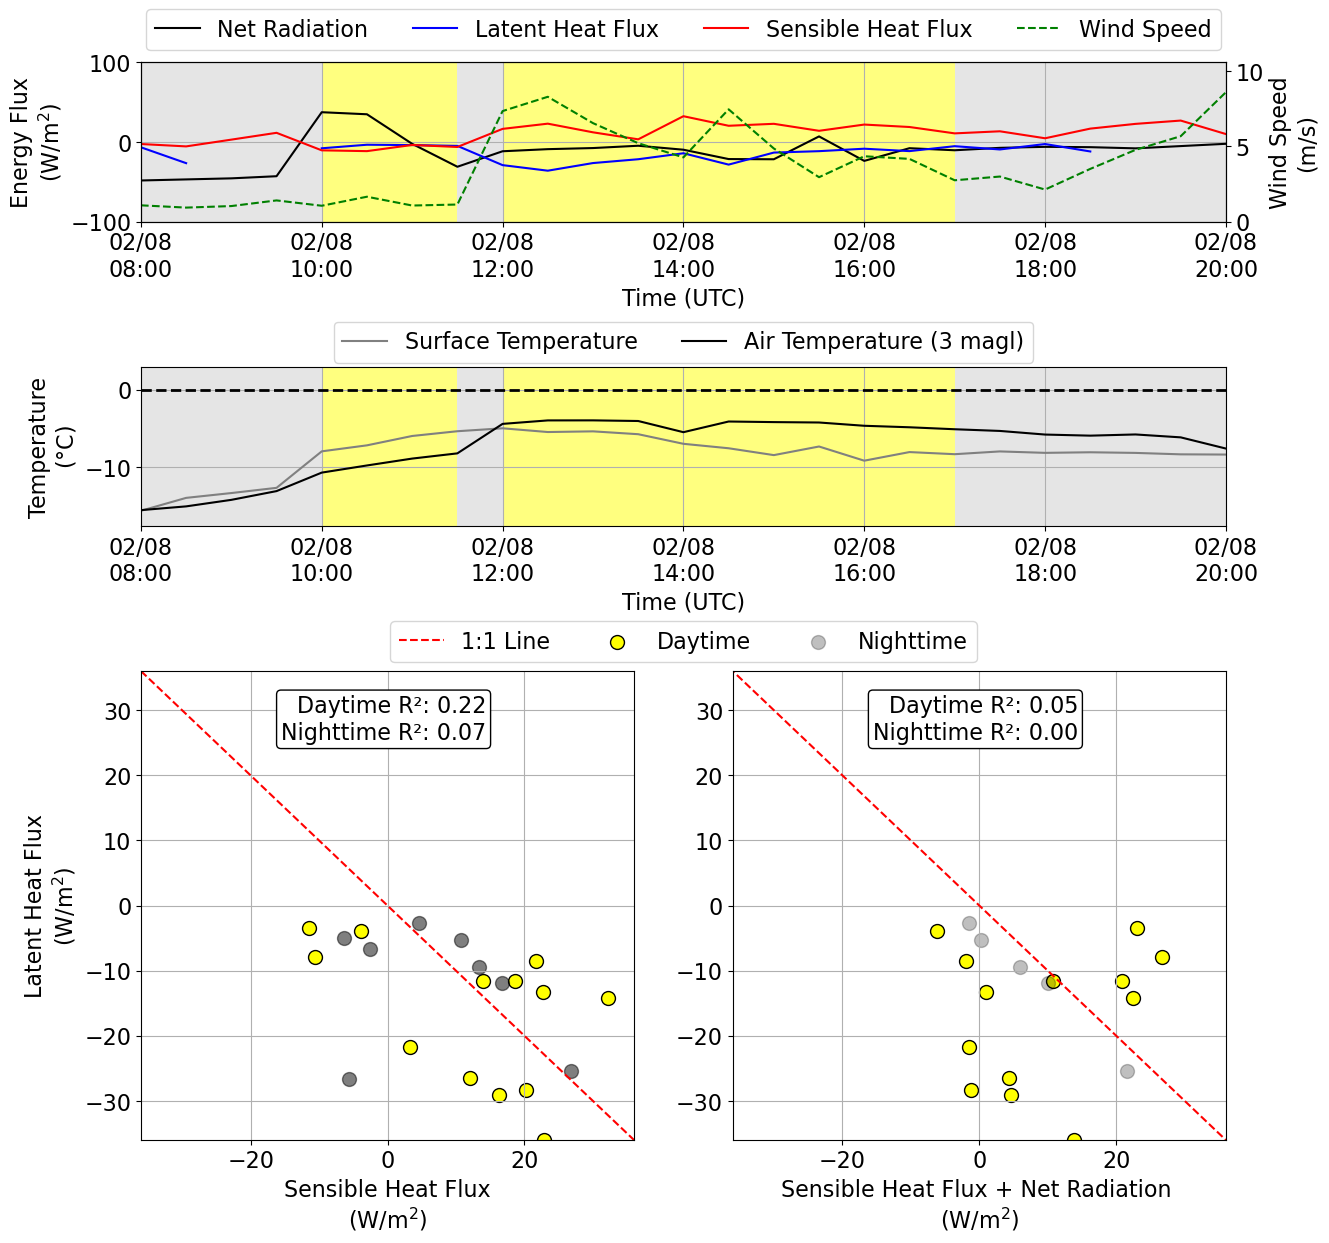

In [38]:
# plot style
plt.style.use('default')
# Create a figure with gridspec layout
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(4, 4, height_ratios=[0.33,0.33, 0.34,0.33], width_ratios=[0.3, 0.3, 0.3, 0.3], hspace=0.9, wspace=0.5)

# Top plot: Net Radiation over time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(sos_30min_rnet_sel.time.values, sos_30min_rnet_sel.values, label='Net Radiation', color='black')
ax1.plot(sos_30min_latent_heat_sel.time.values, -sos_30min_latent_heat_sel.values, label='Latent Heat Flux', color='blue')
ax1.plot(sos_30min_sensible_heat_sel.time.values, -sos_30min_sensible_heat_sel.values, label='Sensible Heat Flux', color='red')
ax1.plot([],[], color='green', ls='--', label='Wind Speed')
# shade daytime/nightime
for i,time in enumerate(sos_30min_daynight_sel.time.values):
    if sos_30min_daynight_sel['daytime'][i]:
        try:
            ax1.axvspan(time, sos_30min_daynight_sel.time.values[i+1], color='yellow', alpha=0.5, ec=None)
        except:
            pass
    else:
        try:
            ax1.axvspan(time, sos_30min_daynight_sel.time.values[i+1], color='black', alpha=0.1, ec=None)
        except:
            pass
ax1.set_xlabel('Time (UTC)', fontsize=16)
ax1.set_ylabel('Energy Flux\n(W/m$^2$)', fontsize=16)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fontsize=16)
ax1.grid(True)
ax1.set_xlim(start, end)
ax1.set_ylim(-100,100)

ax1_twin = ax1.twinx()
ax1_twin.plot(sos_30min_winds_sel.time, sos_30min_winds_sel['spd_10m_c'], color='green', label='Wind Speed', linestyle='--')
ax1_twin.set_ylabel('Wind Speed\n(m/s)', fontsize=16)
ax1_twin.set_ylim(0, sos_30min_winds_sel['spd_10m_c'].max()+2)
ax1_twin.grid(False)


# increase tick label size
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1_twin.tick_params(axis='y', which='major', labelsize=16)
# Format the x-axis ticks to rotate 
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency

# Middle column: Air tempeature, Surface Tempeature, subsurface temperature
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(sos_30min_Tsurf_d_sel.time.values, sos_30min_Tsurf_d_sel.values, color='grey', label='Surface Temperature')
ax2.plot(sos_30min_T_sel.time.values, sos_30min_T_sel['T_3m_c'].values, label='Air Temperature (3 magl)', color='black')
# if the mean difference between air temp and snow temp is greater than 1, plot the snow temp
if (sos_30min_T_sel['T_3m_c']- sos_30min_Tsnow_d_sel[get_near_surface_snow_temp(sos_30min_Tsnow_d_sel)]).mean() > 1*units.units('degC'):
    ax2.plot(sos_30min_T_sel.time.values, sos_30min_Tsnow_d_sel[get_near_surface_snow_temp(sos_30min_Tsnow_d_sel)].values, label='Snow Temperature\n(~10 cm below surface)', color='blue')
else:
    pass
ax2.axhline(y=0, color='black', linestyle='--', lw=2)
# shade daytime/nightime
for i,time in enumerate(sos_30min_daynight_sel.time.values):
    if sos_30min_daynight_sel['daytime'][i]:
        try:
            ax2.axvspan(time, sos_30min_daynight_sel.time.values[i+1], color='yellow', alpha=0.5, ec=None)
        except:
            pass
    else:
        try:
            ax2.axvspan(time, sos_30min_daynight_sel.time.values[i+1], color='black', alpha=0.1, ec=None)
        except:
            pass
ax2.set_xlabel('Time (UTC)', fontsize=16)
ax2.set_ylabel('Temperature\n($\degree$C)', fontsize=16)
ax2.set_ylim(sos_30min_Tsurf_d_sel.min()-2, 3)
ax2.grid(True)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), ncol=3, fontsize=16)
ax2.set_xlim(start, end)

# increase tick label size
ax2.tick_params(axis='both', which='major', labelsize=16)

# Format the x-axis ticks to rotate 
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M"))  # Format: MM/DD HH
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-adjust tick frequency

# Lower left: Latent vs Sensible Heat Flux
ax3 = fig.add_subplot(gs[2:, 0:2])
# calculate best fit line
best_fit_results = variable_linear_regression(-sos_30min_sensible_heat_sel, -sos_30min_latent_heat_sel, daynight=sos_30min_daynight_sel)
# ax3.plot(best_fit_results['X_day'], best_fit_results['Y_day'], color='cyan')
# ax3.plot(best_fit_results['X_night'], best_fit_results['Y_night'], color='magenta')
# annotate the R2 in upper right corner
ax3.text(0.7, 0.95, 
         f"Daytime R²: {best_fit_results['r_value_day']**2:.2f}\nNighttime R²: {best_fit_results['r_value_night']**2:.2f}", ha='right', va='top', transform=ax3.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
         fontsize=16)
ax3.scatter(-sos_30min_sensible_heat_sel[sos_30min_daynight_sel['daytime']].values, -sos_30min_latent_heat_sel[sos_30min_daynight_sel['daytime']].values, 
            color='yellow', label='Daytime', s=100,
            ec='black')
ax3.scatter(-sos_30min_sensible_heat_sel[sos_30min_daynight_sel['nighttime']].values, -sos_30min_latent_heat_sel[sos_30min_daynight_sel['nighttime']].values, 
            color='black', label='Nighttime', alpha=0.5, s=100,
            ec='black')
# scale the 1:1 line with the same limits as the data
# find the absolute max of the data
max_val_all = max(abs(np.array([-sos_30min_latent_heat_sel.max(), -sos_30min_sensible_heat_sel.max(), -sos_30min_latent_heat_sel.min(), -sos_30min_sensible_heat_sel.min()])))
ax3.plot([-max_val_all, max_val_all], [max_val_all,-max_val_all], linestyle='--', color='red', label='1:-1 Line')
ax3.set_xlabel('Sensible Heat Flux\n(W/m$^2$)', fontsize=16)
ax3.set_ylabel('Latent Heat Flux\n(W/m$^2$)', fontsize=16)
ax3.grid(True)
ax3.set_xlim(-max_val_all, max_val_all)
ax3.set_ylim(-max_val_all, max_val_all)
# increase tick label size
ax3.tick_params(axis='both', which='major', labelsize=16)

# Lower center: Latent Heat Flux vs Net Radiation
# ax4 = fig.add_subplot(gs[2, 1])

# Lower right: Sensible Heat Flux vs Net Radiation
ax4 = fig.add_subplot(gs[2:, 2:])
if len(sos_30min_rnet_sel) < len(sos_30min_sensible_heat_sel.time)-5:
    print('Not enough data points for regression')
    # plot on figure this text
    ax4.text(0.5, 0.5, 'Not enough data points for regression', ha='center', va='center', transform=ax4.transAxes)
else:
    best_fit_results = variable_linear_regression(-sos_30min_latent_heat_sel, sos_30min_rnet_sel-sos_30min_sensible_heat_sel.values, daynight=sos_30min_daynight_sel)
    # annotate the R2 in upper right corner
    ax4.text(0.7, 0.95, 
             f"Daytime R²: {best_fit_results['r_value_day']**2:.2f}\nNighttime R²: {best_fit_results['r_value_night']**2:.2f}", ha='right', va='top', transform=ax4.transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
            fontsize=16)

    max_val = max(abs(np.array([sos_30min_latent_heat_sel.max(), sos_30min_rnet_sel.max(), sos_30min_latent_heat_sel.min(), sos_30min_rnet_sel.min()])))
    ax4.plot([-max_val, max_val], [max_val, -max_val], linestyle='--', color='red', label='1:1 Line')
    ax4.scatter(best_fit_results['combined_ds']['rnet'][sos_30min_daynight_sel['daytime']].values, best_fit_results['combined_ds']['latent_heat'][sos_30min_daynight_sel['daytime']].values, 
            color='yellow', label='Daytime', s=100,
            ec='black')
    ax4.scatter(best_fit_results['combined_ds']['rnet'][sos_30min_daynight_sel['nighttime']].values, best_fit_results['combined_ds']['latent_heat'][sos_30min_daynight_sel['nighttime']].values, 
            color='black', label='Νighttime', alpha=0.25, s=100,
            ec='black')
    ax4.set_xlabel('Sensible Heat Flux + Net Radiation \n(W/m$^2$)', fontsize=16)
    ax4.grid(True)
ax4.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.13,), ncols=3, fontsize=16)
ax4.set_xlim(-max_val_all, max_val_all)
ax4.set_ylim(-max_val_all, max_val_all)

# increase tick label size
ax4.tick_params(axis='both', which='major', labelsize=16)
# add colorbar to the right
# cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.2])
# cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(-10, 0)), cax=cbar_ax, label='Surface Temperature [C]')

    


# <a id='toc6_'></a>[Plotting with TROPOE](#toc0_)

In [39]:
w23_sail_tropoe_sel['vapor_pressure'] = calc.vapor_pressure(w23_sail_tropoe_sel['pressure'].metpy.magnitude * units.units('hPa'), w23_sail_tropoe_sel['waterVapor'] * units.units('g/kg')) 
w23_sail_tropoe_sel['saturation_vapor_pressure'] = calc.saturation_vapor_pressure(w23_sail_tropoe_sel['temperature'] * units.units('degC'))
w23_sail_tropoe_sel['vpd'] = w23_sail_tropoe_sel['saturation_vapor_pressure'] - w23_sail_tropoe_sel['vapor_pressure']

(0.0, 1.0)

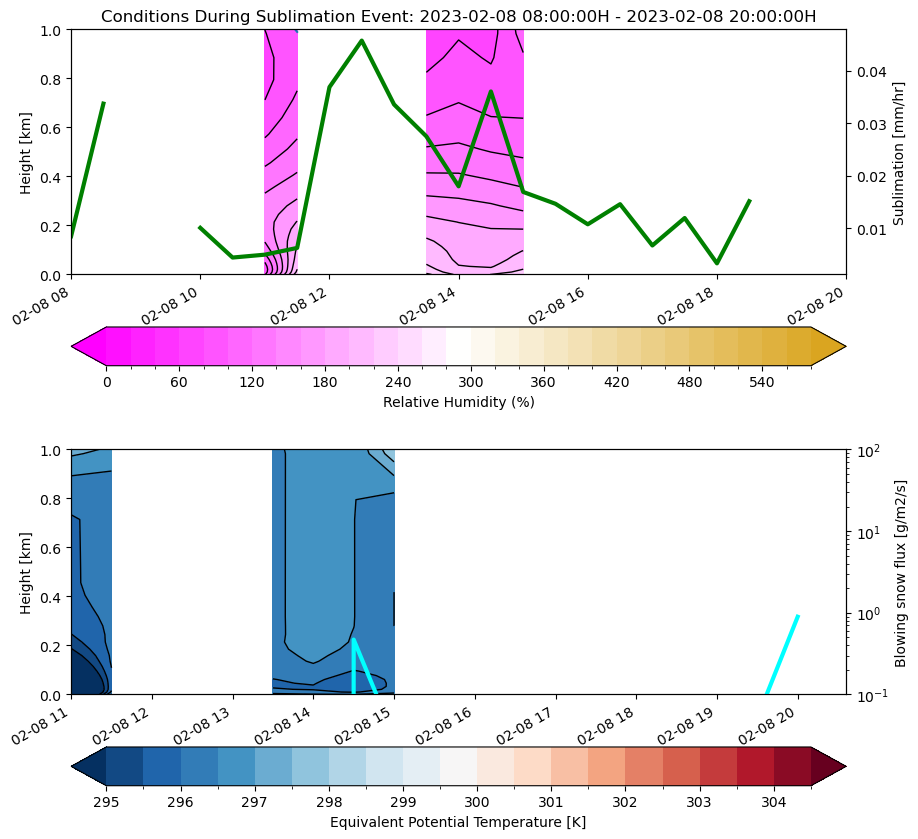

In [40]:
# now try this with matplotlib
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,10))

# Plot the contours of vpd
ax = axs[0]
c_vpd = w23_sail_tropoe_sel['vpd'].plot.contourf(x='time',ax=ax, levels=np.arange(0,600,20), cmap=cmap_r, extend='both', add_colorbar=False)
w23_sail_tropoe_sel['vpd'].plot.contour(x='time',ax=ax, levels=np.arange(0,600,20), colors='k', linewidths=1, linestyles='-')
w23_sail_tropoe_sel['cbh'].plot(ax=ax)
ax2 = ax.twinx()
ax2.plot(sos_30min_sublimation_sel.time, sos_30min_sublimation_sel, color='green', linestyle='-', lw=3, label='Sublimation @ 3m [mm/hr]')
ax2.set_ylabel('Sublimation [mm/hr]')

fig.colorbar(c_vpd, ax=ax, label='Relative Humidity (%)', orientation='horizontal')
ax.set_title(f'Conditions During Sublimation Event: {start}H - {end}H')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [km]')
ax.set_ylim(0,1)
ax.set_xlim(start, end)


# Second plot contours of temperature
ax= axs[1]

c_theta = w23_sail_tropoe_sel['theta'].plot.contourf(x='time',ax=ax, levels=np.arange(295,305,0.5), cmap='RdBu_r', extend='both', add_colorbar=False)
w23_sail_tropoe_sel['theta'].plot.contour(x='time',ax=ax, levels=np.arange(295,305,0.5), colors='k', linewidths=1, linestyles='-')
# also think of adding the sublimation rate
ax2 = ax.twinx()
ax2.plot(sos_30min_bsf_sel.time.values, sos_30min_bsf_sel.values, color='cyan', linestyle='-', lw=3, label='Blowing snow flux [g/m2/s]')
ax2.set_ylabel('Blowing snow flux [g/m2/s]')
ax2.set_yscale('log')
ax2.set_ylim(0.1, 100)
# create third y-axis for blowing snow flux
fig.colorbar(c_theta, ax=ax, label='Equivalent Potential Temperature [K]', orientation='horizontal')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Height [km]')
ax.set_ylim(0,1)
